In [2]:
import os
import re
import sqlite3

import numpy as np
import pandas as pd
import nltk 
from nltk import tokenize
from bs4 import BeautifulSoup
from tensorflow.python.client import device_lib
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Extract data from driver
### Use this when run training in Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive"
!unzip -q "/content/gdrive/My Drive/HATT/database.sqlite.zip"
!unzip -q "/content/gdrive/My Drive/HATT/glove.6B.100d.txt.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 account_kit_replacement
'Account Kit Replacement.gslides'
'AI projects Udacity'
'API for V-chain.gdoc'
'AWS Pinpoint Research Report - Part 2.gslides'
 Badminton.gsheet
'Colab Notebooks'
'Convert Modals to use react-commons ppt chat.gsheet'
'Copy of PPT release 3 APIs.gdoc'
'Design Project Front.gdoc'
'FE design review: Asker Portal.gdoc'
 flower_data.zip
'Frontend design for [GIP-1363] Audit Score MVP.gslides'
'Getting started.pdf'
 HATT
'Powerpoint Feature

## Check if GPU is used

In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4973559839833166883
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9498034580658094178
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6891274687591101127
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11222577227678691120
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Load reviews which have score != 3

In [5]:
conn = sqlite3.connect('database.sqlite')
data = pd.read_sql_query('''
SELECT * FROM Reviews WHERE Score!=3
''',conn)
data.shape

(525814, 10)

## Data processing

### Assign labels for reviews

1, 2, 3 stars => Negative: 0<br/>
4, 5 stars => Positive: 1

In [6]:

data['Score']=data['Score'].map(lambda x:1 if x>3 else 0)
sorteddata= data.sort_values('ProductId',axis=0)
finaldata= sorteddata.drop_duplicates(subset={'UserId','ProfileName',\
        'Time','Text'}, keep='first',inplace=False)

finaldata= finaldata[finaldata['HelpfulnessNumerator'] <= finaldata['HelpfulnessDenominator']]
data= finaldata.sort_values('Time',axis=0)
data.shape

(364171, 10)

### Setup configurations

In [0]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Clean string, make it be lower cased

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [0]:
### Tokenize the given sentences

In [10]:
reviews = []
labels = []
texts = []

print(data.Summary.head(4))
nltk.download('punkt')
for idx in range(data.Summary.shape[0]):
    text = BeautifulSoup(data.Summary.iloc[idx], "lxml")
    text = clean_str(text.get_text())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    labels.append(data.Score.iloc[idx])

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

138706                            EVERY book is educational
138683    This whole series is great way to spend time w...
417839                                 Entertainingl Funny!
346055                              A modern day fairy tale
Name: Summary, dtype: object
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B001EQ58FQ/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B007I7YYGY/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/u

### Tokenize the given sentences

In [11]:
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
print(data.shape)

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

(364171, 15, 100)


In [12]:
labels = to_categorical(np.asarray(labels))
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 32667 unique tokens.


### Split train, validation and test datasets

In [13]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of data tensor: (364171, 15, 100)
Shape of label tensor: (364171, 2)


In [14]:
print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in training and validation set
[ 45671. 245666.]
[11439. 61395.]


## Training processing

### Defind Attention layter

In [0]:
class AttLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim,)), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        # For serialization with 'custom_objects'
        config = super(AttLayer, self).get_config()
        config['attention_dim'] = self.attention_dim

        return config

### Vectorization tokens

We use one of GloVe’s pre-trained embedding dictionaries with 100 dimensions which means that one word will be represented by 100 values in a matrix. This accelerates our training.

For a better comprehension of what those embeddings mean, have a closer a look at an example sentence and a single token. Great is described by 100 values in vector spaces computed by for instance nearest neighbors.

In [16]:
GLOVE_DIR = "./"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SENT_LENGTH,
    trainable=True,
    mask_zero=True
)

### Model

The layers have to be combined on word and sentence level.

TimeDistributed applies to all word level layers on each sentence.

We want to have an output dimensionality of GRU equal to 50 because running it forwards and backwards returns 100 dimensions - which is the dimensionality of our inputs.

Dense implements another layer for document classification. The document vector runs again with the learned weights and biases through a softmax function.

In [19]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
l_att_sent = AttLayer(100)(l_lstm_sent)
preds = Dense(2, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

tracking <tf.Variable 'att_layer_1/W:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_1/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_1/u:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'att_layer_2/W:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_2/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_2/u:0' shape=(100, 1) dtype=float32> u


### Train and save model

In [20]:
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=3, batch_size=50)
model.save('HATT_model.h5')

model fitting - Hierachical attention network


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 291337 samples, validate on 72834 samples
Epoch 1/3
291337/291337 [==============================] - 5186s 18ms/step - loss: 0.1937 - acc: 0.9243 - val_loss: 0.1714 - val_acc: 0.9345
Epoch 2/3
291337/291337 [==============================] - 5122s 18ms/step - loss: 0.1632 - acc: 0.9385 - val_loss: 0.1637 - val_acc: 0.9382
Epoch 3/3
291337/291337 [==============================] - 5177s 18ms/step - loss: 0.1521 - acc: 0.9437 - val_loss: 0.1590 - val_acc: 0.9401


### Evaluation

In [22]:
print(history.history)
precision = history.history['val_precision'][0]
recall = history.history['val_recall'][0]
f_score = (2.0 * precision * recall) / (precision + recall)
print('PRECISION: {}'.format(precision))
print('RECALL: {}'.format(recall))
print('F1-SCORE: {}'.format(f_score))

{'val_loss': [0.1713744040621977, 0.16373307402751167, 0.15904390556289164], 'val_acc': [0.9344948530197144, 0.9381881952285767, 0.9401103854179382], 'loss': [0.1936789219199087, 0.16318467468202674, 0.1521132554798735], 'acc': [0.92427325, 0.9385454, 0.94374555]}


KeyError: ignored

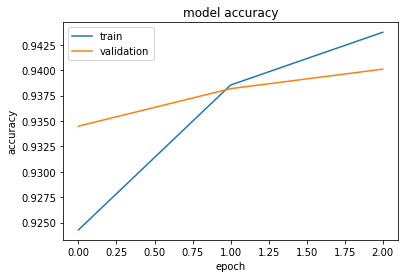

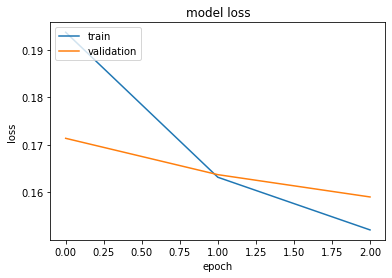

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Testing processing

#### Load and pre-process input

In [0]:
from keras.models import load_model

model = load_model('final_HATT_model.h5', custom_objects={'AttLayer': AttLayer})


def pre_process_input(inputs):
    reviews = []
    labels = []
    texts = []
    for idx in range(len(inputs)):
        new_text = BeautifulSoup(inputs[idx], "lxml")
        new_text = clean_str(str(new_text.get_text()))
        texts.append(new_text)
        sentences = tokenize.sent_tokenize(new_text)
        reviews.append(sentences)

    print('texts', texts)

    data = np.zeros((len(inputs), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            print(j)
            print('sent', sent)
            if j < MAX_SENTS:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
    return data

In [0]:
test_input = [
    "I have bought several of the Vitality canned dog food products and have found them all to be of good. It's totally fine",
    "This product is not bad",
    "This product is nothing than good"
]


trung_test = [
    "Everything of it.",
    "Absolutely nothing!",
    "The package is red.",
    "Yeah, sure. So smooth!",
    "Not one, but many!",
    "This product is second to none.",
    "This is better than nothing.",
]

category_mapping = {
    0: 'Negative',
    1: 'Positive'
}

processed_input = pre_process_input(test_input)

result = model.predict(processed_input)

results = []

for values in result:
    print(values)
    num_cate = list(values).index(max(values))
    string_cate = category_mapping[num_cate]
    results.append(string_cate)
    
print(results)